In [10]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [11]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

In [12]:
symbols, coordinates = qchem.read_structure("h2.xyz")
h, qubits = qchem.molecular_hamiltonian(symbols, coordinates, name="h2")

In [13]:
electrons = 2  # Molecular hydrogen has two electrons

S2 = qchem.spin2(electrons, qubits)

In [14]:
# Hartree-Fock state
hf_state = qchem.hf_state(electrons, qubits)
# generate single- and double-excitations
singles, doubles = qchem.excitations(electrons, qubits)

In [15]:
def circuit(params, wires):
    qml.templates.AllSinglesDoubles(params, wires, hf_state, singles, doubles)

In [17]:
dev = qml.device("lightning.qubit", wires=qubits)

In [18]:
wires = dev.wires.tolist()
print(wires)


@qml.qnode(dev)
def energy_expval(params):
    print(params)
    print(wires)
    print(hf_state)
    print(singles)
    print(doubles)
    qml.templates.AllSinglesDoubles(params, wires, hf_state, singles, doubles)
    
    
    return qml.expval(h)

@qml.qnode(dev)
def S2_expval(params):
    circuit(params, wires)
    return qml.expval(S2)

[0, 1, 2, 3]


In [19]:
def spin(params):
    return -0.5 + np.sqrt(1 / 4 + S2_expval(params))

In [20]:
np.random.seed(1967)
params = np.random.normal(0, np.pi, len(singles) + len(doubles))

In [21]:
energy= energy_expval(params)
print("Energy:", float(energy))
print("Spin:  ", float(spin(params)))

[1.67852596 5.16774531 2.52056489]
[0, 1, 2, 3]
[1 1 0 0]
[[0, 2], [1, 3]]
[[0, 1, 2, 3]]
Energy: -0.2730496738441154
Spin:   0.11000908988780544


In [23]:
# Lets choose RMSPropOptimizer.
# Other alternatives: GradientDescentOptimizer, AdagradOptimizer, AdamOptimizer, ...
opt = qml.RMSPropOptimizer(stepsize=0.2)

In [24]:
iterations = 7

In [25]:
import time
from braket.jobs.metrics import log_metric


def run_vqe(energy_expval, spin, opt, initial_params, iterations):
    energies = []
    spins = []
    params = initial_params

    print(initial_params)
    start = time.time()
    for i in range(iterations):
        params = opt.step(energy_expval, params)

        e = energy_expval(params)
        s = spin(params)

        energies.append(e)
        spins.append(s)

        log_metric(metric_name="energy", value=e, iteration_number=i)

        print(f"Completed iteration {i + 1}")
        print("Energy:", e)
        print("Total spin:", s)
        print("----------------")

    print(f"Optimized energy: {e} Ha")
    print(f"Corresponding total spin: {s}")
    print(f"Elapsed: {time.time()-start} s")
    return energies, spins

In [26]:
energies, spins = run_vqe(energy_expval, spin, opt, params, iterations)

[1.67852596 5.16774531 2.52056489]
Autograd ArrayBox with value [1.67852596 5.16774531 2.52056489]
[0, 1, 2, 3]
[1 1 0 0]
[[0, 2], [1, 3]]
[[0, 1, 2, 3]]
[2.31098123 4.53529012 1.88811002]
[0, 1, 2, 3]
[1 1 0 0]
[[0, 2], [1, 3]]
[[0, 1, 2, 3]]
Metrics - timestamp=1720026098.7304983; energy=-0.5602851198326604; iteration_number=0;
Completed iteration 1
Energy: -0.5602851198326604
Total spin: 0.13287789321454424
----------------
Autograd ArrayBox with value [2.31098123 4.53529012 1.88811002]
[0, 1, 2, 3]
[1 1 0 0]
[[0, 2], [1, 3]]
[[0, 1, 2, 3]]
[2.49988289 4.28666826 2.40053267]
[0, 1, 2, 3]
[1 1 0 0]
[[0, 2], [1, 3]]
[[0, 1, 2, 3]]
Metrics - timestamp=1720026098.7515774; energy=-0.7773309017116152; iteration_number=1;
Completed iteration 2
Energy: -0.7773309017116152
Total spin: 0.0948819812058348
----------------
Autograd ArrayBox with value [2.49988289 4.28666826 2.40053267]
[0, 1, 2, 3]
[1 1 0 0]
[[0, 2], [1, 3]]
[[0, 1, 2, 3]]
[2.81649011 3.85582987 2.74418614]
[0, 1, 2, 3]
[1 1 0 

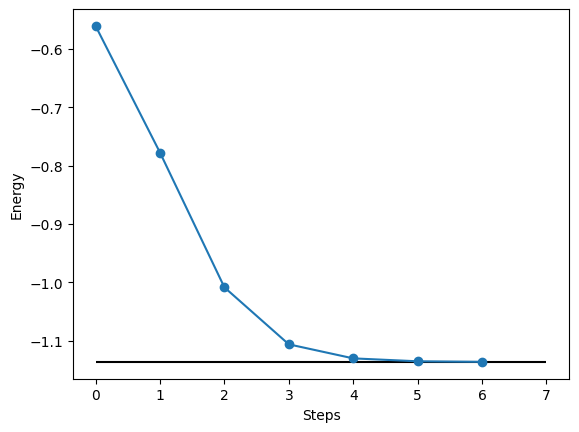

In [27]:
import matplotlib.pyplot as plt

theory_energy = -1.136189454088
theory_spin = 0

plt.hlines(theory_energy, 0, iterations, colors="black")
plt.plot(energies, "o-")
plt.xlabel("Steps")
plt.ylabel("Energy")

axs = plt.gca()